<a href="https://colab.research.google.com/github/elliot35/diamond-analysis-model/blob/master/diamond_analysis_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diamond Analysis and Classification Model

This notebook analyzes diamond characteristics and builds a classification model to predict diamond properties based on images.


## Data Loading and Preprocessing

First, we'll load the diamond dataset and perform initial preprocessing steps.

In [1]:
# Diamond Analysis Model: Image-Based Diamond Characteristic Prediction
# ====================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import glob
import re
import warnings
import kagglehub
from kagglehub import KaggleDatasetAdapter
import requests
from io import BytesIO
import zipfile
import time
import copy
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

Using device: cuda:0
PyTorch version: 2.5.1+cu124
Torchvision version: 0.20.1+cu124


## Exploratory Data Analysis

Let's explore the dataset to understand the distribution of diamond characteristics.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

Mounted at /content/drive


## Download Dataset

Let's download the dataset

In [7]:
# Download latest version
os.environ["KAGGLE_USERNAME"] = 'jhee0006'
path = kagglehub.dataset_download(f'{os.environ["KAGGLE_USERNAME"]}/gia-diamond-images-dataset-2025')

print('Path to dataset files:', path)

100%|██████████| 18.4G/18.4G [02:24<00:00, 137MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jhee0006/gia-diamond-images-dataset-2025/versions/1


In [8]:
# Load the diamond details CSV file
df = pd.read_csv(f'{path}/diamond_scraped/diamond_details.csv')
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows of the dataset:")
display(df.head())

print("\nMissing values in each column:")
print(df.isnull().sum())

Dataset shape: (65693, 18)

First few rows of the dataset:


title  shape  carat color clarity  \
0   0.30 ct K SI1 Round Shape Natural Diamond  Round   0.30     K     SI1   
1   0.31 ct L VS2 Round Shape Natural Diamond  Round   0.31     L     VS2   
2   0.30 ct K VS2 Round Shape Natural Diamond  Round   0.30     K     VS2   
3   0.34 ct J SI2 Round Shape Natural Diamond  Round   0.34     J     SI2   
4  0.18 ct H VVS2 Round Shape Natural Diamond  Round   0.18     H    VVS2   

         cut     polish   symmetry fluorescence          dimensions table  \
0  Very good  Excellent  Very good          NaN   4.24 - 4.18 x 2.6   62%   
1  Excellent  Excellent  Excellent        Faint  4.32 - 4.29 x 2.67   57%   
2  Excellent  Excellent  Excellent       Medium  4.28 - 4.26 x 2.68   57%   
3  Excellent  Excellent  Very good        Faint  4.49 - 4.46 x 2.76   60%   
4  Excellent  Excellent  Excellent        Faint  3.61 - 3.63 x 2.25   58%   

   depth                   girdle culet certificate          stock_number  \
0  61.7%                    Thick   NaN         GIA  AN1E-100757812225767   
1    62%  Medium - Slightly Thick   NaN         GIA  AN1E-100760588693681   
2  62.8%  Medium - Slightly Thick   NaN         GIA  AN1E-100760133040573   
3  61.8%                   Medium   NaN         GIA  AN1E-100748517671222   
4  62.2%                        F   NaN         GIA    EDLI-LD24042949194   

                                         path_to_img  \
0  diamond_scraped/diamond_images/Round/an1e-1007...   
1  diamond_scraped/diamond_images/Round/an1e-1007...   
2  diamond_scraped/diamond_images/Round/an1e-1007...   
3  diamond_scraped/diamond_images/Round/an1e-1007...   
4                                                NaN   

                                         path_to_gia  
0  https://photo.diamondasset.in:8080/Picture/549...  
1  https://photo.diamondasset.in:8080/Picture/338...  
2  https://photo.diamondasset.in:8080/Picture/228...  
3  https://photo.diamondasset.in:8080/Picture/646...  
4   https://certifiedstone.info/certi/LD24042949.pdf


Missing values in each column:
title               0
shape               0
carat               0
color               0
clarity             0
cut                 0
polish              0
symmetry            0
fluorescence    47701
dimensions          0
table               0
depth               0
girdle             54
culet           64834
certificate         0
stock_number        0
path_to_img      4095
path_to_gia      8421
dtype: int64


## Image Dataset Creation

We'll create a custom dataset class to handle diamond images and their labels.

In [9]:
# Check if image paths exist and filter out rows with missing images
df['image_exists'] = df['path_to_img'].apply(lambda x: os.path.exists(f'{path}/{x}') if isinstance(x, str) and len(x) > 0 else False)
df_with_images = df[df['image_exists'] == True].copy()
df_with_images['path_to_img'] = df_with_images['path_to_img'].apply(lambda x: f'{path}/{x}')
print(f"\nRows with valid images: {df_with_images.shape[0]} out of {df.shape[0]} total rows")

# Drop unnecessary columns
df_with_images.drop(['image_exists', 'title', 'stock_number', 'path_to_gia'], axis=1, inplace=True)

# Convert numeric columns to appropriate types
numeric_cols = ['carat', 'table', 'depth']
for col in numeric_cols:
    if col in ['table', 'depth']:
        # For columns that might have % symbols
        df_with_images[col] = df_with_images[col].astype(str).str.replace('%', '').astype(float)
    else:
        # For columns that are already numeric
        df_with_images[col] = df_with_images[col].astype(float)

# Extract dimensions as separate features
def extract_dimensions(dim_str):
    if pd.isna(dim_str) or not isinstance(dim_str, str):
        return pd.Series([np.nan, np.nan, np.nan], index=['width', 'length', 'height'])

    # Try to extract dimensions using regex
    pattern = r'(\d+\.\d+)\s*-\s*(\d+\.\d+)\s*x\s*(\d+\.\d+)'
    match = re.search(pattern, dim_str)

    if match:
        return pd.Series([float(match.group(1)), float(match.group(2)), float(match.group(3))],
                         index=['width', 'length', 'height'])
    else:
        return pd.Series([np.nan, np.nan, np.nan], index=['width', 'length', 'height'])

# Extract dimensions
dimensions_df = df_with_images['dimensions'].apply(extract_dimensions)
df_with_images = pd.concat([df_with_images, dimensions_df], axis=1)

# Display the cleaned dataset
print("\nCleaned dataset:")
display(df_with_images.head())


Rows with valid images: 61598 out of 65693 total rows

Cleaned dataset:


shape  carat color clarity        cut     polish   symmetry fluorescence  \
0  Round   0.30     K     SI1  Very good  Excellent  Very good          NaN   
1  Round   0.31     L     VS2  Excellent  Excellent  Excellent        Faint   
2  Round   0.30     K     VS2  Excellent  Excellent  Excellent       Medium   
3  Round   0.34     J     SI2  Excellent  Excellent  Very good        Faint   
5  Round   0.31     K     VS1  Excellent  Excellent  Excellent       Strong   

           dimensions  table  depth                   girdle culet  \
0   4.24 - 4.18 x 2.6   62.0   61.7                    Thick   NaN   
1  4.32 - 4.29 x 2.67   57.0   62.0  Medium - Slightly Thick   NaN   
2  4.28 - 4.26 x 2.68   57.0   62.8  Medium - Slightly Thick   NaN   
3  4.49 - 4.46 x 2.76   60.0   61.8                   Medium   NaN   
5  4.32 - 4.29 x 2.71   56.0   62.9  Medium - Slightly Thick   NaN   

  certificate                                        path_to_img  width  \
0         GIA  /root/.cache/kagglehub/datasets/jhee0006/gia-d...   4.24   
1         GIA  /root/.cache/kagglehub/datasets/jhee0006/gia-d...   4.32   
2         GIA  /root/.cache/kagglehub/datasets/jhee0006/gia-d...   4.28   
3         GIA  /root/.cache/kagglehub/datasets/jhee0006/gia-d...   4.49   
5         GIA  /root/.cache/kagglehub/datasets/jhee0006/gia-d...   4.32   

   length  height  
0    4.18    2.60  
1    4.29    2.67  
2    4.26    2.68  
3    4.46    2.76  
5    4.29    2.71

## Exploratory Data Analysis

Let's explore our data to better understand the distribution of diamond characteristics.

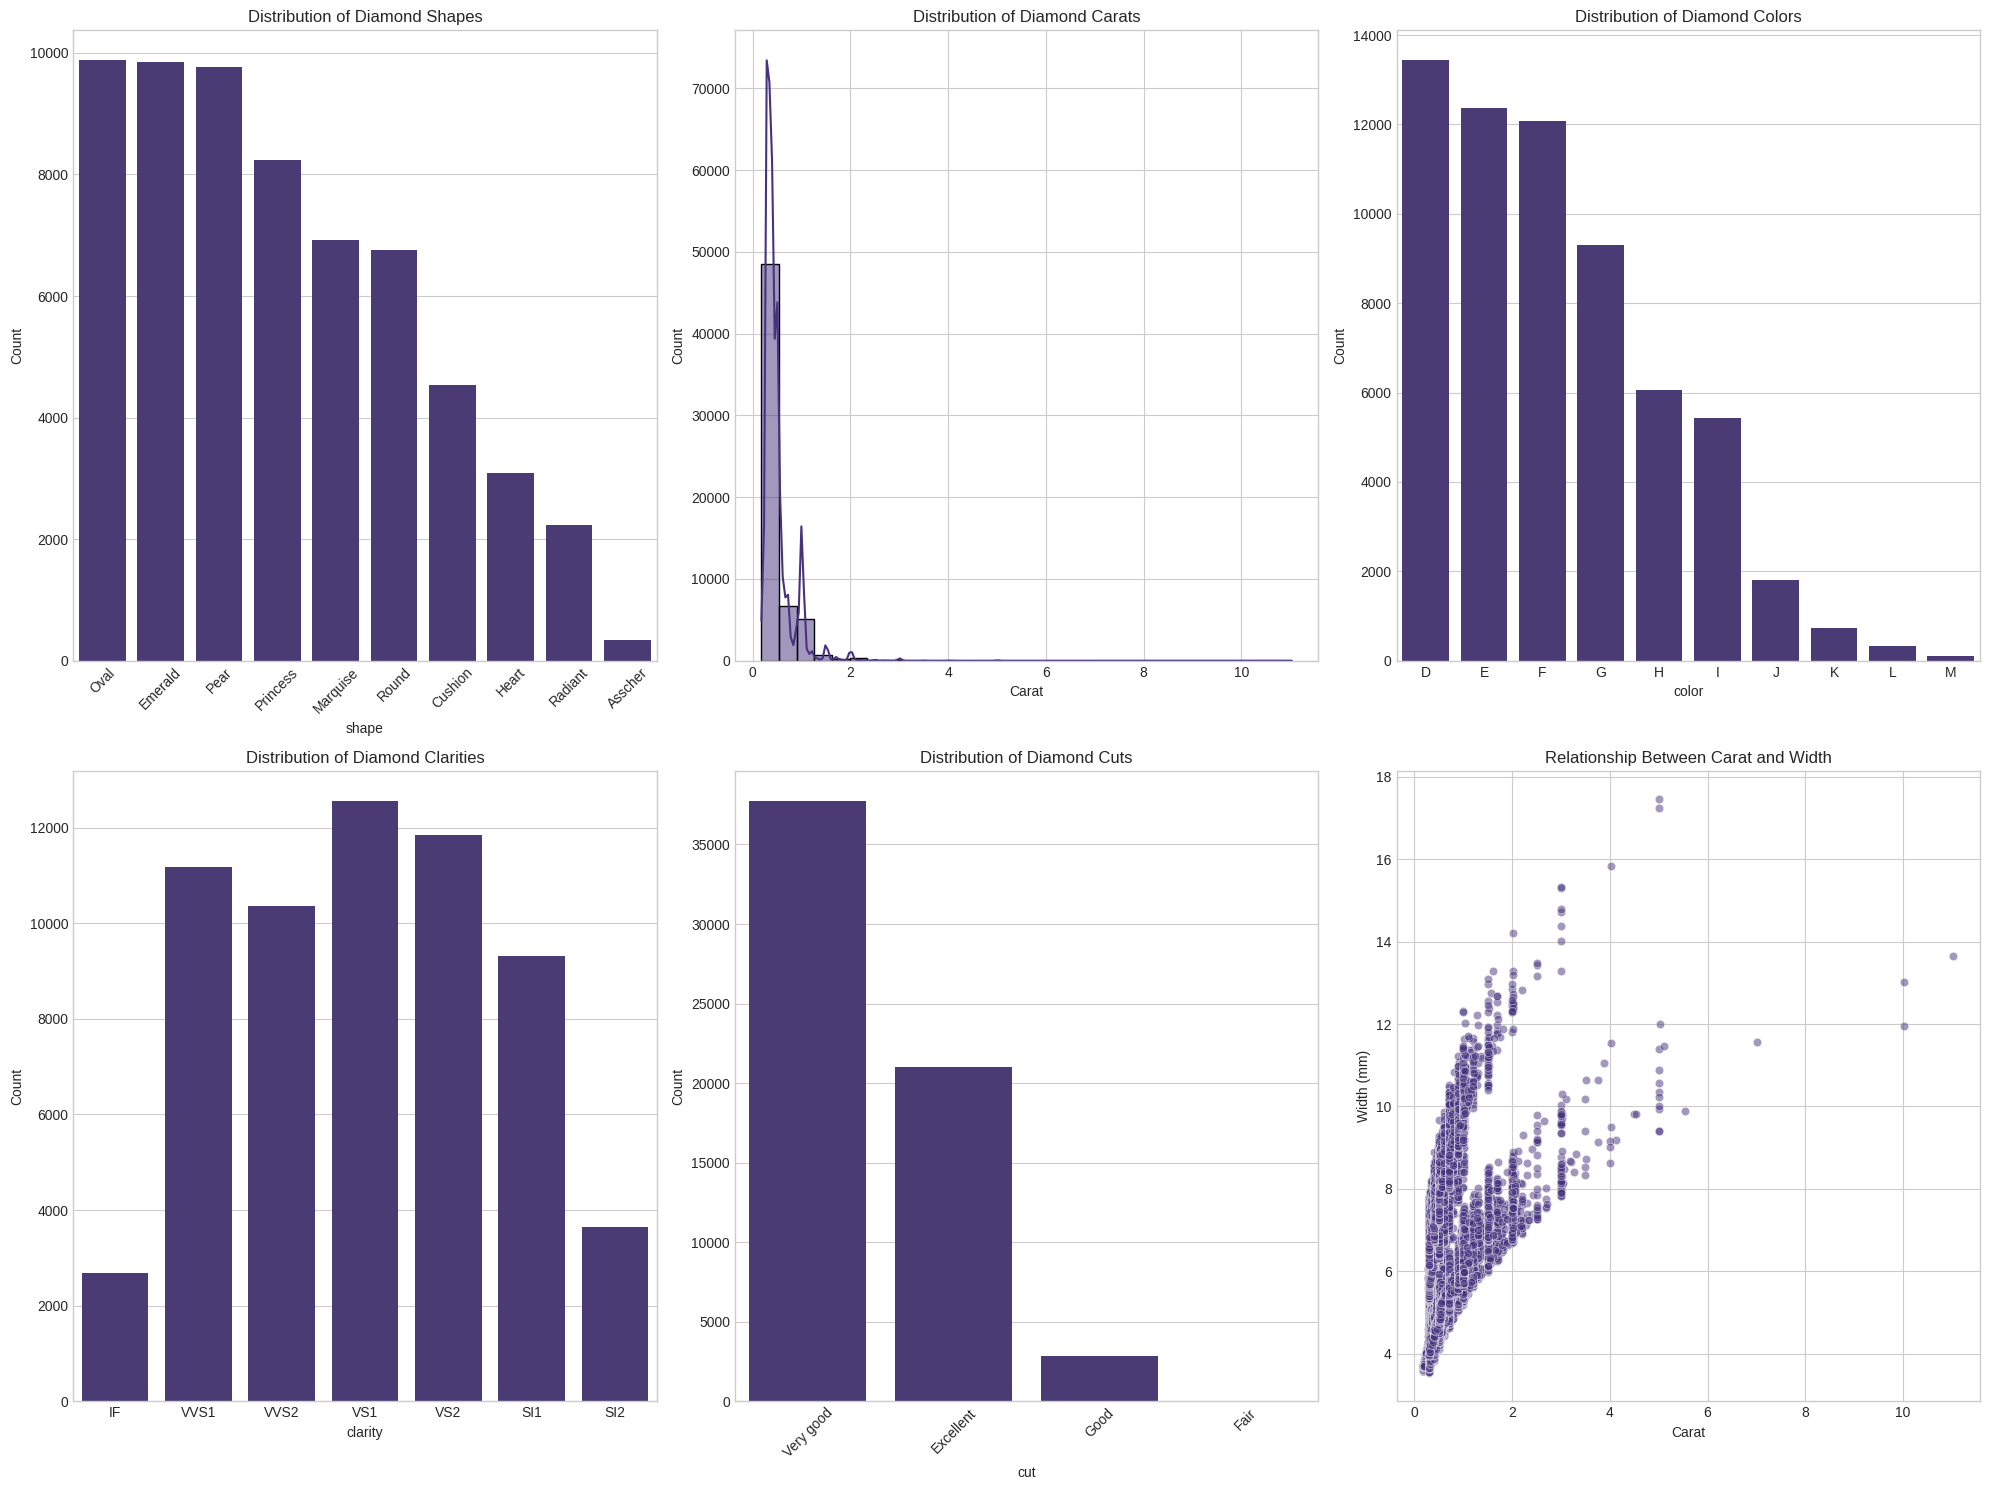

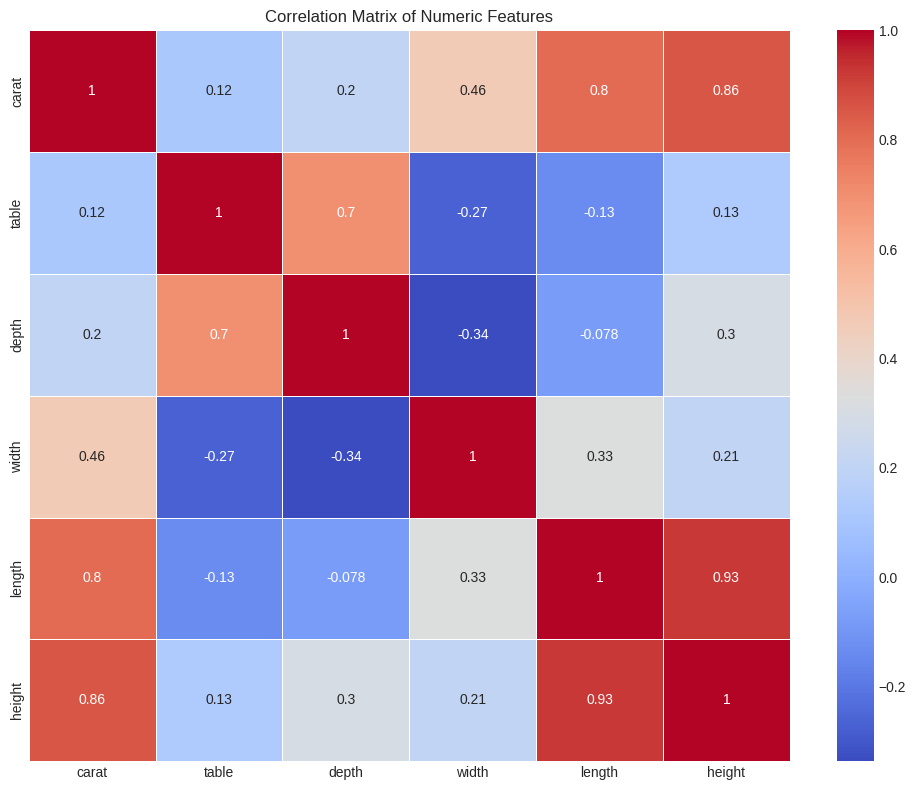

In [10]:
# Set up the plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Create a figure for the plots
plt.figure(figsize=(20, 15))

# 1. Distribution of diamond shapes
plt.subplot(2, 3, 1)
shape_counts = df_with_images['shape'].value_counts()
sns.barplot(x=shape_counts.index, y=shape_counts.values)
plt.title('Distribution of Diamond Shapes')
plt.xticks(rotation=45)
plt.ylabel('Count')

# 2. Distribution of diamond carats
plt.subplot(2, 3, 2)
sns.histplot(df_with_images['carat'], bins=30, kde=True)
plt.title('Distribution of Diamond Carats')
plt.xlabel('Carat')
plt.ylabel('Count')

# 3. Distribution of diamond colors
plt.subplot(2, 3, 3)
color_counts = df_with_images['color'].value_counts().sort_index()
sns.barplot(x=color_counts.index, y=color_counts.values)
plt.title('Distribution of Diamond Colors')
plt.ylabel('Count')

# 4. Distribution of diamond clarities
plt.subplot(2, 3, 4)
clarity_order = ['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2']
clarity_counts = df_with_images['clarity'].value_counts()
clarity_counts = clarity_counts.reindex(clarity_order) if all(c in clarity_counts.index for c in clarity_order) else clarity_counts
sns.barplot(x=clarity_counts.index, y=clarity_counts.values)
plt.title('Distribution of Diamond Clarities')
plt.ylabel('Count')

# 5. Distribution of diamond cuts
plt.subplot(2, 3, 5)
cut_counts = df_with_images['cut'].value_counts()
sns.barplot(x=cut_counts.index, y=cut_counts.values)
plt.title('Distribution of Diamond Cuts')
plt.xticks(rotation=45)
plt.ylabel('Count')

# 6. Relationship between carat and dimensions
plt.subplot(2, 3, 6)
sns.scatterplot(data=df_with_images, x='carat', y='width', alpha=0.5)
plt.title('Relationship Between Carat and Width')
plt.xlabel('Carat')
plt.ylabel('Width (mm)')

plt.tight_layout()
plt.show()

# Correlation matrix for numeric features
numeric_df = df_with_images[['carat', 'table', 'depth', 'width', 'length', 'height']].copy()
plt.figure(figsize=(10, 8))
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

## Model Architecture

Define a CNN model for diamond classification based on ResNet50.

In [11]:
# Custom Dataset class for diamond images
class DiamondDataset(Dataset):
    def __init__(self, dataframe, img_dir, target_col, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.target_col = target_col
        self.transform = transform

        # Encode target labels
        self.label_encoder = LabelEncoder()
        self.dataframe['encoded_target'] = self.label_encoder.fit_transform(self.dataframe[target_col])
        self.classes = self.label_encoder.classes_

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['path_to_img']

        try:
            # Load image
            image = Image.open(img_path).convert('RGB')

            # Apply transformations
            if self.transform:
                image = self.transform(image)

            # Get label
            label = self.dataframe.iloc[idx]['encoded_target']

            return image, label

        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a placeholder image and label in case of error
            placeholder = torch.zeros((3, 224, 224))
            return placeholder, 0

# Define image transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Define a CNN model for diamond classification
class DiamondCNN(nn.Module):
    def __init__(self, num_classes, feature_extract=False):
        super(DiamondCNN, self).__init__()

        # Load a pre-trained ResNet model
        self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        # Freeze parameters if feature extracting
        if feature_extract:
            for param in self.model.parameters():
                param.requires_grad = False

        # Modify the final fully connected layer for our number of classes
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)

## Model Training

Initialize and train the diamond classification model.

In [34]:
# Function to train the model
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, scheduler=None):
    since = time.time()

    # Initialize variables to track best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Lists to track metrics
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass (track history if only in train)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if scheduler is not None and phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Track history
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

                # Deep copy the model if it's the best so far
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'val_loss': val_loss_history,
        'val_acc': val_acc_history
    }

# Let's train a model for diamond shape classification
target_column = 'shape'  # We'll start with shape classification

# Split the data into train and validation sets
train_df, val_df = train_test_split(df_with_images, test_size=0.2, random_state=42, stratify=df_with_images[target_column])

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

# Create datasets
train_dataset = DiamondDataset(train_df, '', target_column, transform=data_transforms['train'])
val_dataset = DiamondDataset(val_df, '', target_column, transform=data_transforms['val'])

# Create dataloaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

# Initialize the model
num_classes = len(train_dataset.classes)
model = DiamondCNN(num_classes=num_classes, feature_extract=True)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train the model
import time
import copy

model, history = train_model(
    model,
    dataloaders,
    criterion,
    optimizer,
    num_epochs=1,
    scheduler=scheduler
)

model_file_name = f'diamond_{target_column}_classifier.pth'

# Save the model
torch.save(model.state_dict(), f'diamond_{target_column}_classifier.pth')

Training set size: 49278
Validation set size: 12320
Epoch 1/1
----------
Error loading image /root/.cache/kagglehub/datasets/jhee0006/gia-diamond-images-dataset-2025/versions/1/diamond_scraped/diamond_images/Cushion/10we-242511-219_6282359.jpg: cannot identify image file '/root/.cache/kagglehub/datasets/jhee0006/gia-diamond-images-dataset-2025/versions/1/diamond_scraped/diamond_images/Cushion/10we-242511-219_6282359.jpg'
train Loss: 0.1951 Acc: 0.9362
val Loss: 0.0320 Acc: 0.9910

Training complete in 3m 36s
Best val Acc: 0.9910


## Upload Model

In [31]:
# Upload the model file
handle = f'jhee0006/cnn/pyTorch/diamond-{target_column}-classifier-model'
local_model_dir = f'/content/{model_file_name}'

kagglehub.model_upload(handle, local_model_dir, version_notes='Initial diamond shape classification model', license_name='Apache 2.0')

Uploading Model https://www.kaggle.com/models/jhee0006/cnn/pyTorch/diamond-cut-classifier-model ...
Starting upload for file /content/diamond_cut_classifier.pth


Uploading: 100%|██████████| 98.6M/98.6M [00:01<00:00, 72.1MB/s]

Upload successful: /content/diamond_cut_classifier.pth (94MB)


Your model instance has been created.
Files are being processed...
See at: https://www.kaggle.com/models/jhee0006/cnn/pyTorch/diamond-cut-classifier-model


## Model Evaluation

Evaluate the model on the validation set and generate performance metrics.

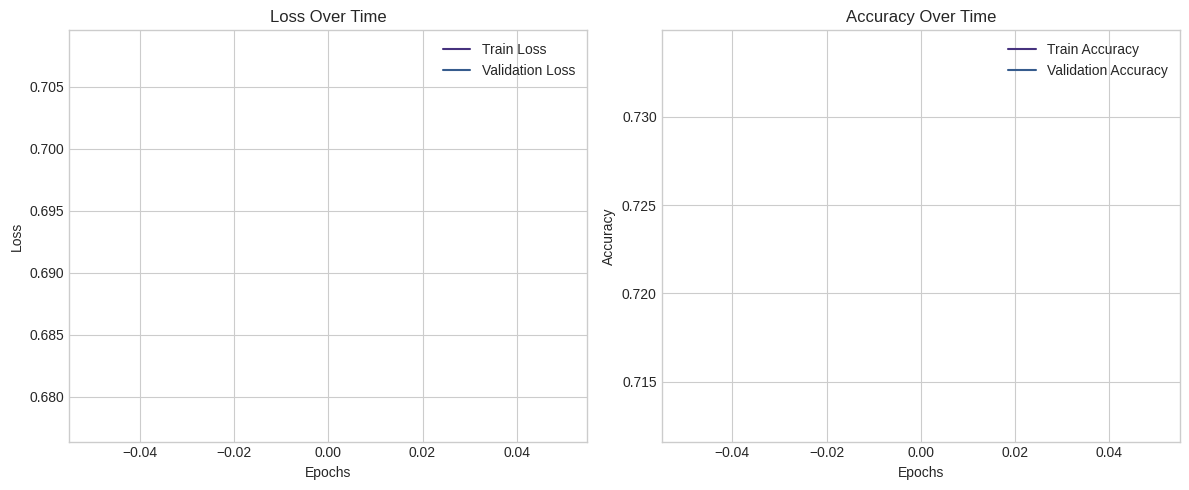

Error loading image /root/.cache/kagglehub/datasets/jhee0006/gia-diamond-images-dataset-2025/versions/1/diamond_scraped/diamond_images/Cushion/10we-242511-219_6282359.jpg: cannot identify image file '/root/.cache/kagglehub/datasets/jhee0006/gia-diamond-images-dataset-2025/versions/1/diamond_scraped/diamond_images/Cushion/10we-242511-219_6282359.jpg'
Validation Accuracy: 0.7338

Classification Report:
              precision    recall  f1-score   support

   Excellent       0.70      0.61      0.65      4201
        Fair       0.00      0.00      0.00         2
        Good       0.00      0.00      0.00       568
   Very good       0.75      0.86      0.80      7549

    accuracy                           0.73     12320
   macro avg       0.36      0.37      0.36     12320
weighted avg       0.70      0.73      0.71     12320



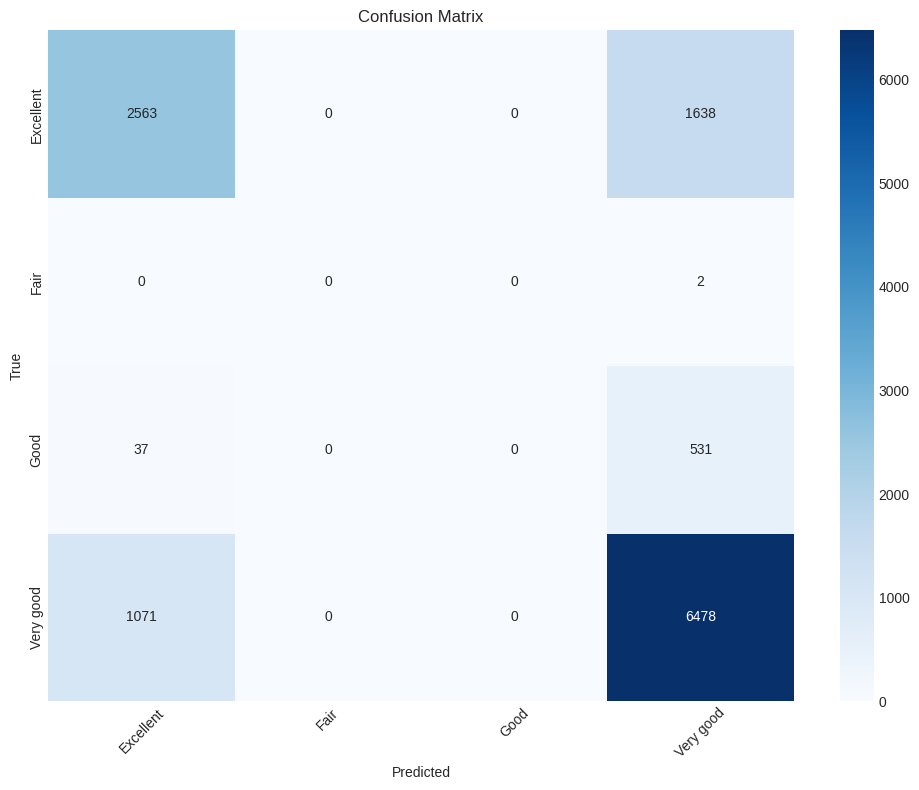

In [29]:
# Plot training and validation metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy Over Time')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Function to evaluate the model on the validation set
def evaluate_model(model, dataloader, classes):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Validation Accuracy: {accuracy:.4f}")

    # Generate classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return accuracy, all_preds, all_labels

# Evaluate the model
accuracy, predictions, true_labels = evaluate_model(model, val_dataloader, train_dataset.classes)

## Test the model

Testing model on a batch of images:


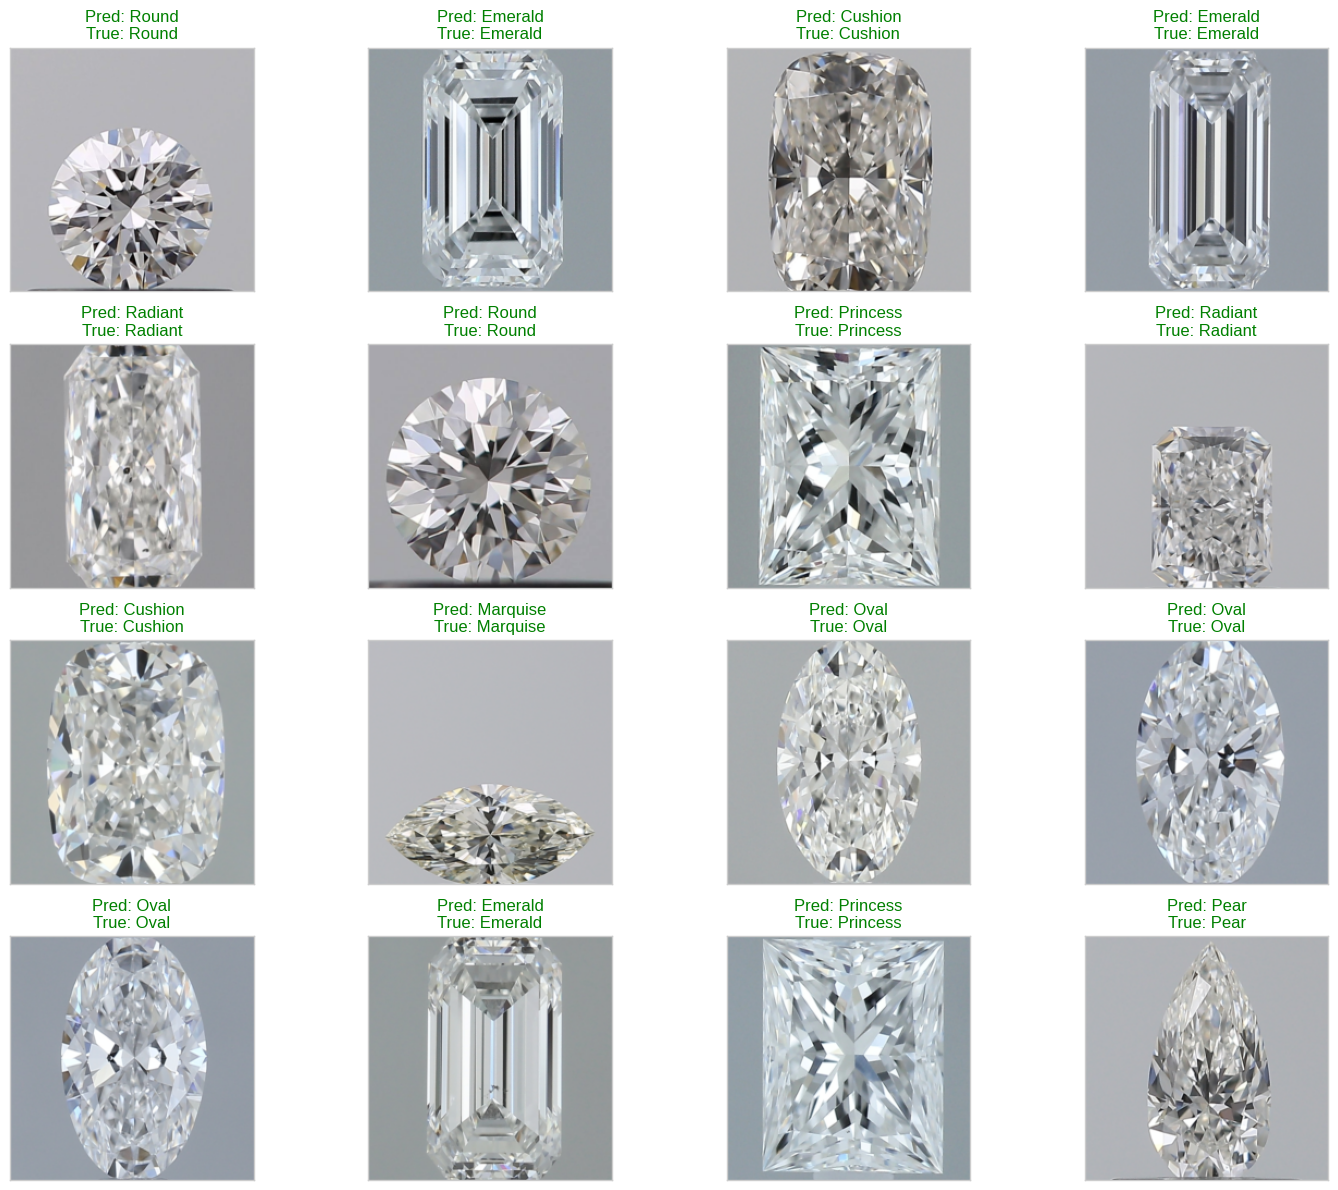

Test Accuracy: 1.0000 (32/32)

Testing model on individual images:

Predicting image: an1e-100760459602_6738600.jpg


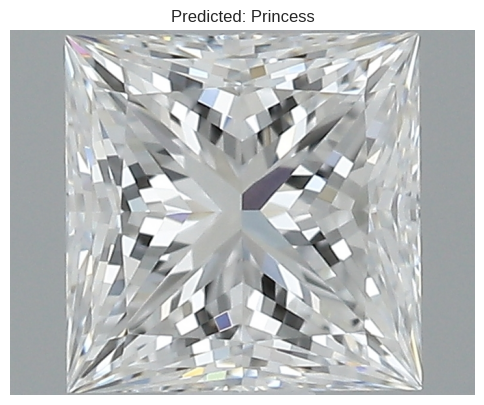

Prediction: Princess

Predicting image: an1e-100760380636_4963309.jpg


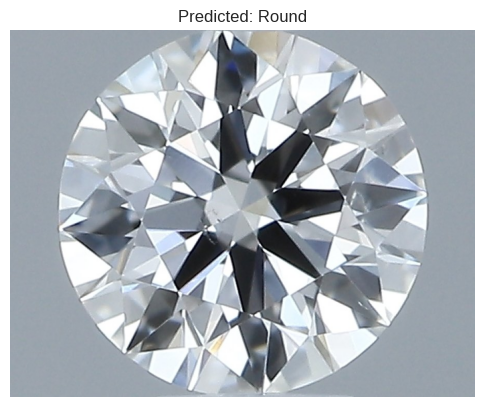

Prediction: Round

Predicting image: an1e-100761033902_6721633.jpg


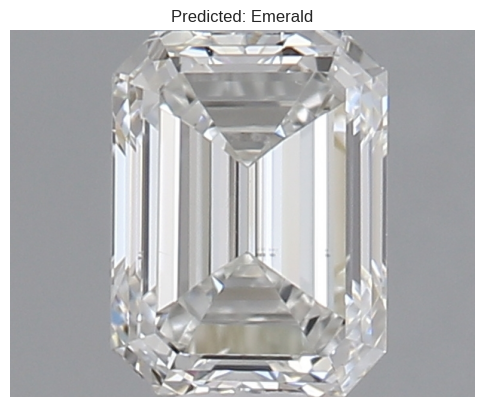

Prediction: Emerald

Predicting image: an1e-100758084657_5762531.jpg


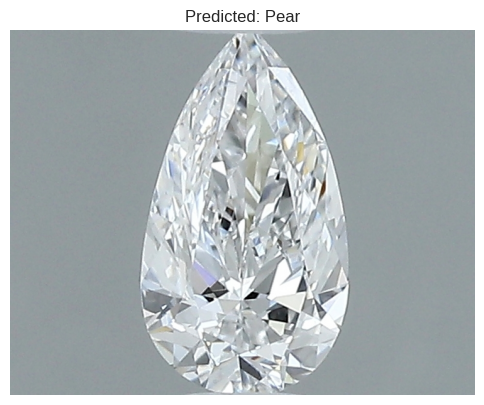

Prediction: Pear

Predicting image: an1e-100760284863_5317060.jpg


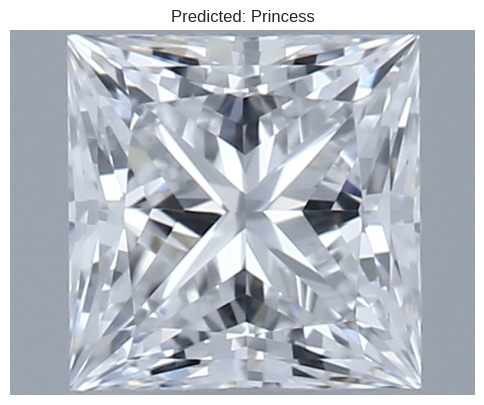

Prediction: Princess

Comprehensive evaluation on the test set:
Test Set Accuracy: 0.9912

Classification Report:
              precision    recall  f1-score   support

     Asscher       1.00      1.00      1.00        34
     Cushion       0.98      0.99      0.98       453
     Emerald       1.00      1.00      1.00       985
       Heart       1.00      0.97      0.99       308
    Marquise       0.99      0.99      0.99       692
        Oval       0.99      0.99      0.99       988
        Pear       0.99      1.00      0.99       976
    Princess       1.00      1.00      1.00       823
     Radiant       0.98      0.95      0.97       224
       Round       0.98      1.00      0.99       676

    accuracy                           0.99      6159
   macro avg       0.99      0.99      0.99      6159
weighted avg       0.99      0.99      0.99      6159



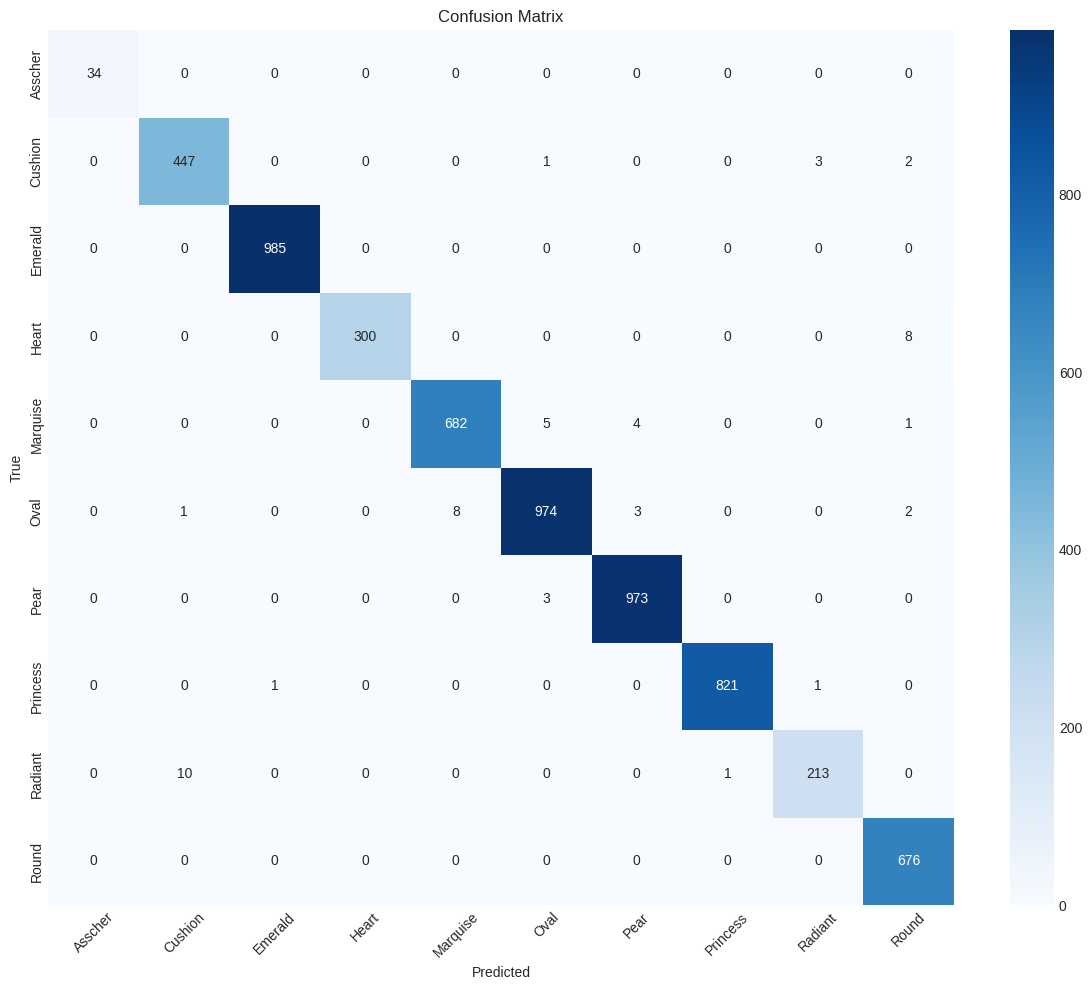


Testing model robustness with image augmentations:


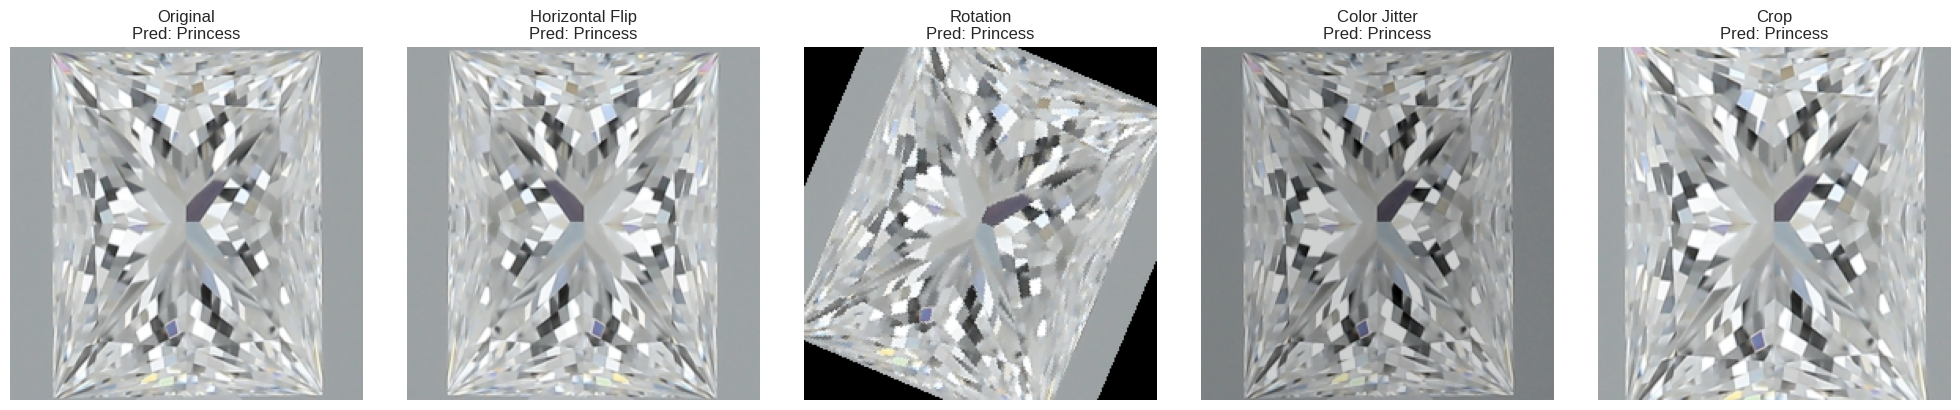

In [35]:
# Testing the Diamond Analysis Model
# ==================================

# Function to test the model on new images
def test_model_on_new_images(model, test_dataloader, class_names):
    """
    Test the model on new images and visualize results

    Args:
        model: Trained PyTorch model
        test_dataloader: DataLoader with test images
        class_names: List of class names
    """
    model.eval()

    # Get a batch of test images
    images, labels = next(iter(test_dataloader))
    images = images.to(device)
    labels = labels.to(device)

    # Make predictions
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    # Plot the images with predictions
    fig = plt.figure(figsize=(15, 12))
    for i in range(min(16, len(images))):
        ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])

        # Convert tensor to numpy for visualization
        img = images[i].cpu().numpy().transpose((1, 2, 0))

        # Denormalize the image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax.imshow(img)

        # Set the title with prediction and ground truth
        pred_class = class_names[preds[i]]
        true_class = class_names[labels[i]]
        title_color = 'green' if preds[i] == labels[i] else 'red'
        ax.set_title(f'Pred: {pred_class}\nTrue: {true_class}', color=title_color)

    plt.tight_layout()
    plt.show()

    # Calculate and print accuracy
    correct = (preds == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f} ({correct}/{total})')

# Function to test on a single image
def predict_single_image(model, image_path, transform, class_names):
    """
    Make a prediction on a single image

    Args:
        model: Trained PyTorch model
        image_path: Path to the image file
        transform: Image transformations to apply
        class_names: List of class names

    Returns:
        Predicted class name
    """
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, pred = torch.max(output, 1)

    predicted_class = class_names[pred.item()]

    # Display the image with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_class}')
    plt.axis('off')
    plt.show()

    return predicted_class

# Create a test dataset and dataloader
test_df, remaining_df = train_test_split(df_with_images, test_size=0.9, random_state=42, stratify=df_with_images[target_column])
test_dataset = DiamondDataset(test_df, '', target_column, transform=data_transforms['val'])
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Test the model on a batch of images
print("Testing model on a batch of images:")
test_model_on_new_images(model, test_dataloader, test_dataset.classes)

# Test the model on individual images
print("\nTesting model on individual images:")
# Get a few sample image paths from the test set
sample_image_paths = test_df['path_to_img'].sample(5).tolist()

for img_path in sample_image_paths:
    if os.path.exists(img_path):
        print(f"\nPredicting image: {os.path.basename(img_path)}")
        predicted_class = predict_single_image(model, img_path, data_transforms['val'], test_dataset.classes)
        print(f"Prediction: {predicted_class}")
    else:
        print(f"Image not found: {img_path}")

# Comprehensive evaluation on the test set
def evaluate_test_set(model, test_dataloader, class_names):
    """
    Perform a comprehensive evaluation on the test set

    Args:
        model: Trained PyTorch model
        test_dataloader: DataLoader with test data
        class_names: List of class names
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Set Accuracy: {accuracy:.4f}")

    # Generate classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return accuracy

# Evaluate on the full test set
print("\nComprehensive evaluation on the test set:")
test_accuracy = evaluate_test_set(model, test_dataloader, test_dataset.classes)

# Test model robustness with augmented images
def test_model_robustness(model, image_path, class_names):
    """
    Test model robustness by applying various augmentations to a single image

    Args:
        model: Trained PyTorch model
        image_path: Path to the image file
        class_names: List of class names
    """
    # Load the image
    image = Image.open(image_path).convert('RGB')

    # Define augmentations to test
    augmentations = {
        'Original': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'Horizontal Flip': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=1.0),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'Rotation': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomRotation(degrees=30),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'Color Jitter': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'Crop': transforms.Compose([
            transforms.Resize((250, 250)),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }

    # Make predictions with each augmentation
    model.eval()
    fig, axs = plt.subplots(1, len(augmentations), figsize=(20, 4))

    for i, (aug_name, transform) in enumerate(augmentations.items()):
        # Apply transformation
        img_tensor = transform(image).unsqueeze(0).to(device)

        # Make prediction
        with torch.no_grad():
            output = model(img_tensor)
            _, pred = torch.max(output, 1)

        predicted_class = class_names[pred.item()]

        # Display the augmented image with prediction
        # Convert tensor to numpy for visualization
        img_np = img_tensor[0].cpu().numpy().transpose((1, 2, 0))

        # Denormalize the image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = std * img_np + mean
        img_np = np.clip(img_np, 0, 1)

        axs[i].imshow(img_np)
        axs[i].set_title(f'{aug_name}\nPred: {predicted_class}')
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Test model robustness on a sample image
if len(sample_image_paths) > 0 and os.path.exists(sample_image_paths[0]):
    print("\nTesting model robustness with image augmentations:")
    test_model_robustness(model, sample_image_paths[0], test_dataset.classes)
else:
    print("No valid sample images found for robustness testing")

# Test model on different diamond characteristics
def test_model_on_different_characteristics(df, image_dir, characteristics, model_path_template):
    """
    Test models trained on different diamond characteristics

    Args:
        df: DataFrame with diamond data
        image_dir: Directory containing images
        characteristics: List of characteristics to test
        model_path_template: Template for model path with {} placeholder for characteristic
    """
    results = {}

    for characteristic in characteristics:
        # Load the model
        model_path = model_path_template.format(characteristic)
        if not os.path.exists(model_path):
            print(f"Model for {characteristic} not found at {model_path}")
            continue

        # Create dataset
        test_df, _ = train_test_split(df, test_size=0.9, random_state=42, stratify=df[characteristic])
        test_dataset = DiamondDataset(test_df, image_dir, characteristic, transform=data_transforms['val'])
        test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

        # Load model
        num_classes = len(test_dataset.classes)
        model = DiamondCNN(num_classes=num_classes)
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.to(device)

        # Evaluate
        print(f"\nEvaluating model for {characteristic}:")
        accuracy = evaluate_test_set(model, test_dataloader, test_dataset.classes)
        results[characteristic] = accuracy

    # Compare results
    if results:
        plt.figure(figsize=(10, 6))
        plt.bar(results.keys(), results.values())
        plt.title('Model Accuracy Across Different Diamond Characteristics')
        plt.xlabel('Characteristic')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1)
        plt.xticks(rotation=45)
        for i, (k, v) in enumerate(results.items()):
            plt.text(i, v + 0.02, f'{v:.4f}', ha='center')
        plt.tight_layout()
        plt.show()

# Uncomment to test models for different characteristics
# characteristics_to_test = ['shape', 'color', 'clarity', 'cut', 'polish']
# test_model_on_different_characteristics(
#     df_with_images,
#     '',
#     characteristics_to_test,
#     'diamond_{}_classifier.pth'
# )